In [2]:
import numpy as np 
import pandas as pd 
from reduced_form_models import * 

from time import time 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score

import tensorflow as tf  

# from keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

from Neural_network_utils import ParamGenerator

import matplotlib.pyplot as plt

In [3]:
def NN_generator(InputShape, out_shape, nLayers, nNodes, activationFun='relu', loss='mse', optimizer='rmsprop', LR=0.001, lr_scheduler=None, BatchNorm=0, show=1):
    
    # First Layer : Input Layer
    input_layer = Input(shape=InputShape)
    
    # Defining the first hidden layer
    x = Dense(nNodes, activation=activationFun)(input_layer)
    
    if BatchNorm==1:
        
        x = BatchNormalization()(x)
    
    # adding more layers
    
    i = 1
    
    while i<nLayers:
        
        x = Dense(nNodes, activation=activationFun)(x)
        if BatchNorm==1:
            x = BatchNormalization()(x)
        i+=1
    
    # adding the last layer
    x = Dense(out_shape, activation='linear')(x)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    
    # # Compiling the model 
    
    # Configuring the optimizer with the specified learning rate
    if optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=LR)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=LR)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=LR)
    else:
        raise ValueError("Unsupported optimizer. Choose 'rmsprop', 'adam', or 'sgd'.")
    
    # Compiling the model
    model.compile(loss=loss, optimizer=opt)
    
    # ## Different Optimizers are compared in companion notebook
    # model.compile(loss=loss, optimizer=optimizer)
    
    if show==1:
        print(model.summary())
        
    return model




def price_generator(data):
    
    result = np.empty((len(data), 2))
    
    for i in range(0, len(data)):
        
        T = data[i,0] # bond maturity
        r = data[i,1] # risk free-rate
        P = np.exp(-r*T) # risk-free discoutn factor 
        x0 = data[i,2] # risky factor 
        rec_rate = data[i,3] # recovery rate 
        k = data[i, 4] # speed of mean reversion first factor 
        theta = data[i, 5] # long run mean 
        sigma = data[i, 6] # vol 
        
        rZCB = risky_zcb0(x0, k, theta, sigma, T, P, rec_rate) # risky zcb
        s = -np.log(rZCB)/T - r # risky spread 
        result[i,0] = s 
        result[i, 1] = rZCB
        
    result = np.hstack((data, result))
    
    columns = ['T', 'r', 'x0', 'rec_rate', 'k', 'theta', 'sigma', 'spread', 'rZCB']
    
    result = pd.DataFrame(result, columns=columns)    
    
    return result

In [4]:
# Fisxing the seed

np.random.seed(42)

In [5]:
# Generate the dataset

n = int(5e4)

T_lb = .5 
T_ub = 10 

r_lb = -0.01
r_ub = .05 

x0_lb = 0 
x0_ub = 1 

rec_rate_lb = 0 
rec_rate_ub = 1

k_lb = 1e-1 
k_ub = 2 

theta_lb = 1e-4
theta_ub = .35 

sigma_lb = 1e-4
sigma_ub = 1 

lb = np.array([T_lb, r_lb, x0_lb, rec_rate_lb, k_lb, theta_lb, sigma_lb])
ub = np.array([T_ub, r_ub, x0_ub, rec_rate_ub, k_ub, theta_ub, sigma_ub])

data = ParamGenerator(n, len(lb), lb, ub)

start = time() 

dataset = price_generator(data)

end = time() 

elapsed_time = end-start

print(f"Elapsed time: {elapsed_time}")

Elapsed time: 0.9473967552185059


In [6]:
# Dividing the dataset into train and test set

X = dataset.loc[:, ['T', 'r', 'spread']]
Y = dataset.loc[:, ['rZCB']]


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [9]:
# Constructing the feedforward neural network
nNodes = 500
nLayers = 4
InputShape = len(X.columns)
outShape= 1
BatchSize = 32
nEpochs = 80

model1 = NN_generator(InputShape, outShape, nLayers, nNodes, 'relu','mse','adam')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_5 (Dense)             (None, 500)               2000      
                                                                 
 dense_6 (Dense)             (None, 500)               250500    
                                                                 
 dense_7 (Dense)             (None, 500)               250500    
                                                                 
 dense_8 (Dense)             (None, 500)               250500    
                                                                 
 dense_9 (Dense)             (None, 1)                 501       
                                                                 
Total params: 754,001
Trainable params: 754,001
Non-trainab

In [11]:
# Start the training

start = time()
result = model1.fit(x_train, y_train, epochs=nEpochs, batch_size=BatchSize, validation_split = 0.25, verbose = 0)
end = time()

print('Elapsed time : ' + str(end-start))

Elapsed time : 313.30109119415283


In [12]:
predictions = model1.predict(x_test)
    
r2 = r2_score(y_test, predictions)

print(f"R² score: {r2}")

391/391 [==============================] - 1s 2ms/step
R² score: 0.9999754804006976


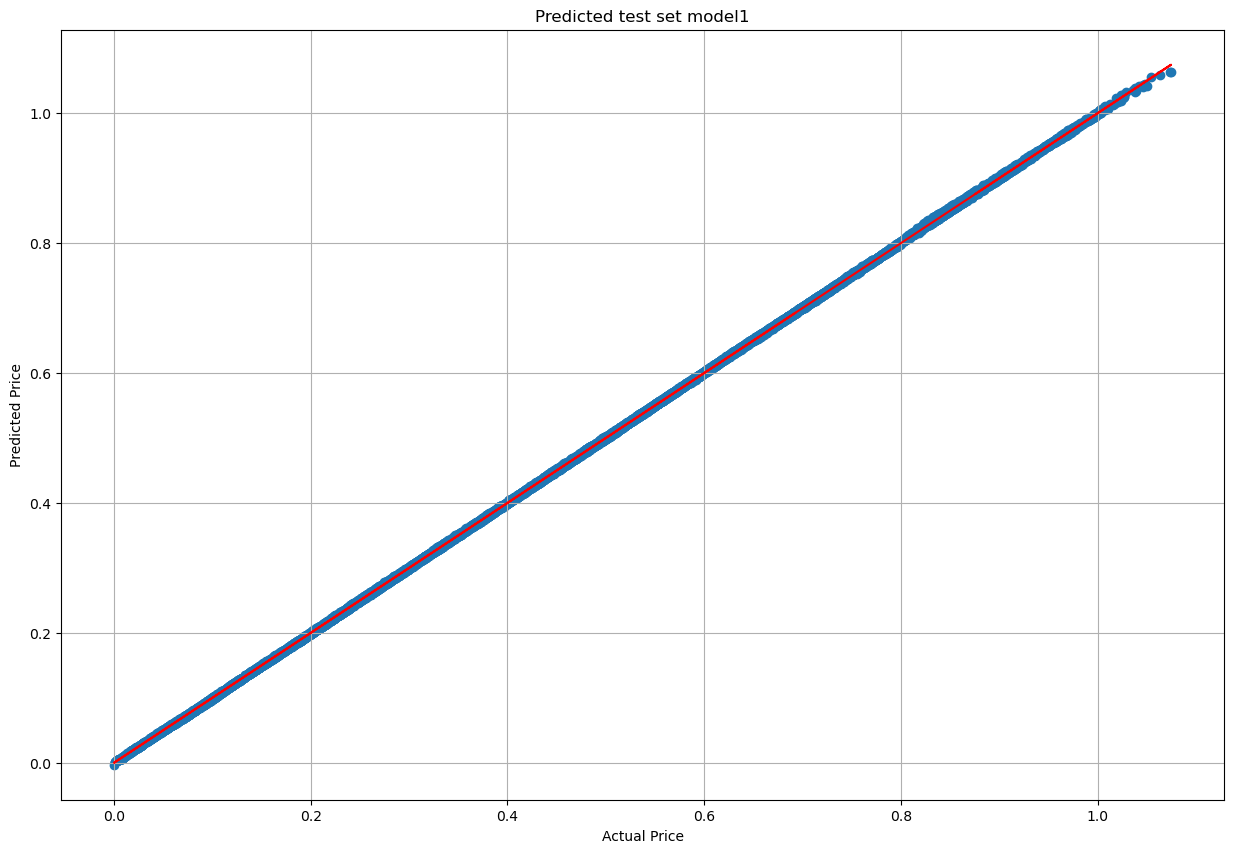

In [13]:
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot(y_test, y_test, 'r')
plt.grid(True)
plt.title('Predicted test set model1')
plt.show()

In [14]:
train_loss = result.history['loss']
val_loss = result.history['val_loss']

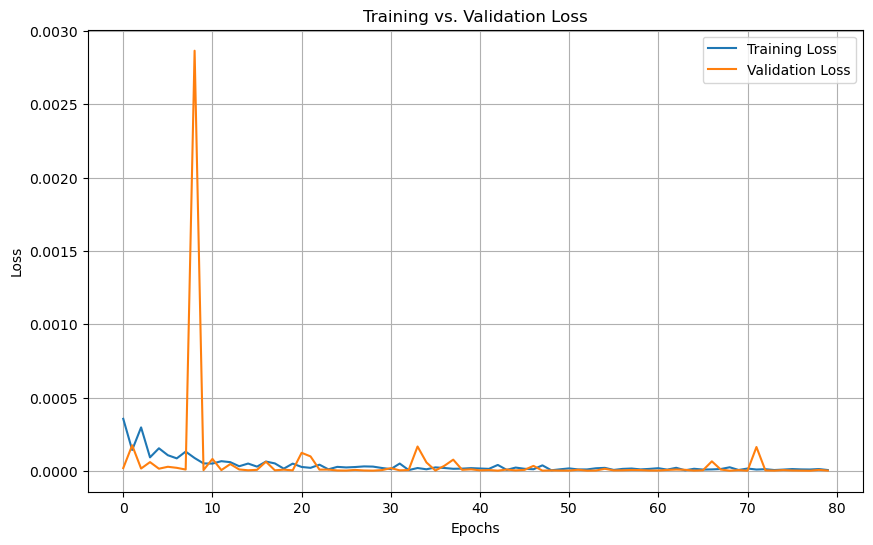

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()